In [2]:
from itertools import permutations, product

import functools

import tqdm

import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, auc, confusion_matrix, balanced_accuracy_score, precision_recall_curve, auc, roc_curve, roc_auc_score
from sklearn.inspection import permutation_importance

from imblearn.ensemble import BalancedBaggingClassifier
from xgboost import XGBClassifier

import numpy as np
from numpy import mean,std

import pickle

from os import path

import matplotlib.pyplot as plt

from warnings import simplefilter
from collections import OrderedDict

simplefilter(action="ignore", category=pd.errors.PerformanceWarning)



In [5]:
df = pd.read_csv('info.csv')
# print(df.loc[:, df.columns != 'isZoonotic'])
# print(df)
# print(len(df.columns))

X_train, X_test, y_train, y_test = train_test_split(df.loc[:, df.columns != 'isZoonotic'], df['isZoonotic'], test_size=0.2, random_state=1)
for col in df.columns:
    col != 'isZoonotic' and X_train[col].isnull().sum() != 0 and print(X_train[col].isnull().sum())


Series([], Name: isZoonotic, dtype: float64)


In [6]:
lrmodel = LogisticRegression(
    multi_class="multinomial", max_iter=1000,
    fit_intercept=False, tol=0.001, solver='saga', random_state=42)
lrmodel.fit(X_train, y_train)

LogisticRegression(fit_intercept=False, max_iter=1000,
                   multi_class='multinomial', random_state=42, solver='saga',
                   tol=0.001)

In [7]:
# all 0s for some reason
print(X_test[:10])
predictions = lrmodel.predict(X_test)
print(accuracy_score(y_test, predictions))

      tggc  ttcc  tatg  gtat  aatg  acag  atgg  tact  tcaa  aggc  ...  ggca  \
1302     8    15    16    12    20    11     9    17    12     6  ...     6   
6596    14    74    40    46    60    26    28    46    69    15  ...    24   
4095    13    14    22    10    15     7    10    14    13     3  ...     4   
7284   596   815   619   630   939   551   688   532  1294   287  ...   533   
4899    40    57    82    52    75    25    57    74    55    29  ...    20   
6289    41    51    56    30    75    50    66    33    83    28  ...    39   
7830   267   118    20    34    38   109   141    38   115   255  ...   312   
2048   243   201    33    71    25   100   107    73   178   246  ...   226   
7122    97   129   192   220   319   141   171   271   284    52  ...    63   
7488    13     5     8     5     9     2     4     4    15     9  ...     7   

      gacc  agct  agta  tatc  acgt  cact  cttg  ctat  tctt  
1302     6     8     4     8    10     5    16    12    16  
6596    

[-1.00077355e-04 -2.21716298e-05 -1.12589697e-04 -3.12945811e-05
 -5.60850947e-05  7.16889711e-05 -1.23146683e-04 -9.45145806e-06
 -2.23049633e-04 -6.74218830e-06 -1.44735451e-05  5.51764194e-05
 -4.58302713e-05 -2.20939378e-05 -1.02321876e-04 -3.63198926e-05
  2.23245319e-05 -1.77573679e-04  2.45316665e-05 -1.93231885e-04
  1.16943467e-04  2.23690780e-05  6.54925247e-07 -1.52051269e-04
  4.54214582e-05 -5.15778555e-05  6.43144986e-05 -4.42385469e-05
  3.99985940e-05 -1.57707559e-04  1.20973832e-04 -6.06829666e-06
 -6.34827934e-06 -6.96424694e-05 -2.01068449e-04 -1.80031602e-04
 -1.53804241e-04 -1.85223431e-05 -3.86825061e-06 -7.95205383e-06
  2.20248138e-05  2.62013431e-05 -1.62273722e-04 -5.45293284e-05
 -2.71168138e-04  7.86248585e-05 -2.18448593e-05  3.38993046e-05
 -3.35067775e-05 -5.18445080e-05  7.79860282e-05  1.02241427e-04
 -4.72981218e-05 -7.78649494e-05 -6.90881362e-05 -5.21578375e-05
 -7.76810898e-05 -6.89614333e-05 -1.02381773e-04  5.01298777e-05
  1.37419704e-04  1.36801

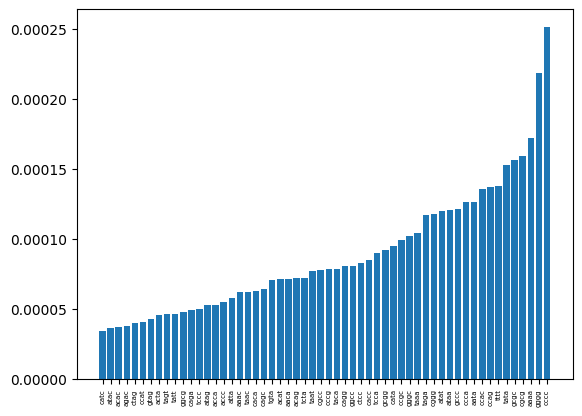

In [8]:
results = lrmodel.coef_[0]
print(results)

l = zip([x for x in X_test.columns.values],results)
l = list(l)
res = sorted(l, key= lambda x: x[1])

plt.xticks(rotation=90)
plt.tick_params(axis='x', which='major', labelsize=5)

plt.bar([x[0] for x in res[200:]], [x[1] for x in res[200:]])
plt.show()

In [9]:
knntest = BalancedBaggingClassifier(base_estimator=KNeighborsClassifier(n_neighbors = 1, n_jobs = 1), n_estimators = 10, n_jobs = 1)

knntest.fit(X_train, y_train)
# knn = KNeighborsClassifier(n_neighbors=5)

BalancedBaggingClassifier(base_estimator=KNeighborsClassifier(n_jobs=1,
                                                              n_neighbors=1),
                          n_jobs=1)

In [10]:
predictions = knntest.predict(X_test)
print(predictions[:10])
print(accuracy_score(y_test, predictions))

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
0.9178154825026511


In [11]:

randforest = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(max_features="sqrt"))

randforest.fit(X_train, y_train)

BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(max_features='sqrt'))

In [ ]:
def saveModel(model, name, X_test, y_test, params=None, dir='curr_models', gradBoost=False, xgBoost=False):
    
    
    if not path.exists(f"{dir}/{name}.pkl"):
        print("does not exist")

        pickle.dump(model, open(f'{dir}/{name}.pkl', 'wb'))
    else:
        predictions = model.predict(X_test)
        currAcc = accuracy_score(y_test, predictions)

        pickled_model = pickle.load(open(f'{dir}/{name}.pkl', 'rb'))
        
        if gradBoost:
            # get features here 
            cols_when_model_builds = pickled_model.feature_names_in_
            X_test=X_test[cols_when_model_builds]
        elif xgBoost:
            # put features into the same order that the model was trained in
            cols_when_model_builds = pickled_model.get_booster().feature_names
            X_test=X_test[cols_when_model_builds]
        
        # .values?
        
        picklePredictions=pickled_model.predict(X_test)
        pickleAcc=accuracy_score(y_test, picklePredictions)
        
        if currAcc > pickleAcc:
            print("update!")
            print(confusion_matrix(y_test, picklePredictions))

            print("curr", currAcc, "pickle", pickleAcc)
            pickle.dump(model, open(f'{dir}/{name}.pkl', 'wb'))

            if params != None:
                pickle.dump(params, open(f'{dir}/{name}-params.pkl', 'wb'))
        else:
            print("no update")
            print("curr", currAcc, "pickle", pickleAcc)
            print(confusion_matrix(y_test, picklePredictions))

            model=pickled_model
    return model

In [ ]:
saveModel(randforest, "randforest", X_test, y_test)

predictions = randforest.predict(X_test)
print(accuracy_score(y_test, predictions))

# for i in range(1000):
#     predictions[i] != y_test_list[i] and print(predictions[i], "vs", y_test_list[i])

update!
[[1583   51]
 [ 249    3]]
curr 0.9321314952279958 pickle 0.8409331919406151
0.9321314952279958


/Users/benjaminli/opt/miniconda3/envs/seq/lib/python3.8/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


In [ ]:
probability_predictions = randforest.predict_proba(X_test)
preds = randforest.predict(X_test)
print(accuracy_score(y_test, preds))


0.9321314952279958


In [ ]:
lr_list = [0.05, 0.075, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65,0.7, 0.75, 0.8, 0.85, 1]

parameters={
   "n_estimators":100, # 200 kind of overfits I think
    "max_features":2,
    "max_depth":6,
    "random_state":0,
    "min_sample_split":50,
    "subsample":0.8
    # "warm_start":True
}


# careful with WARM START - only works after a lot of iterations
for learning_rate in lr_list:
    gradBoost = GradientBoostingClassifier(n_estimators=parameters['n_estimators'], 
    learning_rate=learning_rate, max_features=parameters['max_features'], 
    max_depth=parameters['max_depth'], random_state=parameters['random_state'], 
    min_samples_split=parameters['min_sample_split'], subsample=parameters['subsample']
    )

    parameters['learning_rate']=learning_rate
    gradBoost.fit(X_train, y_train)

    cols_when_model_builds = gradBoost.feature_names_in_
    X_test=X_test[cols_when_model_builds]
    
    testingAcc = accuracy_score(y_test, gradBoost.predict(X_test))
    trainingAcc = accuracy_score(y_train, gradBoost.predict(X_train))
    
    print("Learning rate: ", learning_rate)
    # print("Accuracy score (training): {0:.3f}".format(trainingAcc))
    print("Accuracy score (validation): {0:.3f}".format(testingAcc))
    # print(f"Feature importance {gradBoost.feature_importances_}")

    # pickle.dump(gradBoost, open('gradBoost.pkl', 'wb'))
    saveModel(gradBoost, "gradBoost", X_test, y_test, parameters, gradBoost=True)

Learning rate:  0.05
Accuracy score (validation): 0.953
no update
curr 0.953340402969247 pickle 0.9623541887592789
[[1621   13]
 [  58  194]]
Learning rate:  0.075
Accuracy score (validation): 0.956
no update
curr 0.9559915164369035 pickle 0.9623541887592789
[[1621   13]
 [  58  194]]
Learning rate:  0.1
Accuracy score (validation): 0.958
no update
curr 0.9581124072110286 pickle 0.9623541887592789
[[1621   13]
 [  58  194]]
Learning rate:  0.15
Accuracy score (validation): 0.958
no update
curr 0.9581124072110286 pickle 0.9623541887592789
[[1621   13]
 [  58  194]]
Learning rate:  0.2
Accuracy score (validation): 0.959
no update
curr 0.9591728525980912 pickle 0.9623541887592789
[[1621   13]
 [  58  194]]
Learning rate:  0.25
Accuracy score (validation): 0.958
no update
curr 0.9575821845174973 pickle 0.9623541887592789
[[1621   13]
 [  58  194]]
Learning rate:  0.3
Accuracy score (validation): 0.959
no update
curr 0.9591728525980912 pickle 0.9623541887592789
[[1621   13]
 [  58  194]]
Le

In [ ]:
lr_list = [0.05, 0.075, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65,0.7, 0.75, 0.8, 0.85, 1]

parameters={
   "n_estimators":100, # 200 kind of overfits I think
    "max_features":2,
    "max_depth":6,
    "random_state":0,
    "subsample":0.8,
    'lambda': 0.5, # regularization?
    'alpha': 0.5
}



for learning_rate in lr_list:
    xgBoost = XGBClassifier(n_estimators=parameters['n_estimators'], 
    learning_rate=learning_rate, 
    max_depth=parameters['max_depth'], random_state=parameters['random_state'], 
    subsample=parameters['subsample'], 
    )

    parameters['learning_rate']=learning_rate
    xgBoost.fit(X_train, y_train)

    # ALWAYS reset feature names
    cols_when_model_builds = xgBoost.get_booster().feature_names
    X_test=X_test[cols_when_model_builds]

    testingAcc = accuracy_score(y_test, xgBoost.predict(X_test))
    trainingAcc = accuracy_score(y_train, xgBoost.predict(X_train))
    
    print("Learning rate: ", learning_rate)
    # print("Accuracy score (training): {0:.3f}".format(trainingAcc))
    print("Accuracy score (validation): {0:.3f}".format(testingAcc))
    # print(f"Feature importance {gradBoost.feature_importances_}")

    # pickle.dump(gradBoost, open('gradBoost.pkl', 'wb'))
    saveModel(xgBoost, "xgBoost", X_test, y_test, parameters, xgBoost=True)

Learning rate:  0.05
Accuracy score (validation): 0.958
no update
curr 0.9581124072110286 pickle 0.9639448568398727
[[1617   17]
 [  51  201]]
Learning rate:  0.075
Accuracy score (validation): 0.960
no update
curr 0.9597030752916225 pickle 0.9639448568398727
[[1617   17]
 [  51  201]]
Learning rate:  0.1
Accuracy score (validation): 0.958
no update
curr 0.9575821845174973 pickle 0.9639448568398727
[[1617   17]
 [  51  201]]
Learning rate:  0.15
Accuracy score (validation): 0.963
no update
curr 0.9628844114528102 pickle 0.9639448568398727
[[1617   17]
 [  51  201]]
Learning rate:  0.2
Accuracy score (validation): 0.961
no update
curr 0.9607635206786851 pickle 0.9639448568398727
[[1617   17]
 [  51  201]]
Learning rate:  0.25
Accuracy score (validation): 0.962
no update
curr 0.9623541887592789 pickle 0.9639448568398727
[[1617   17]
 [  51  201]]
Learning rate:  0.3
Accuracy score (validation): 0.963
no update
curr 0.9634146341463414 pickle 0.9639448568398727
[[1617   17]
 [  51  201]]
L

In [ ]:
# Models within "orig_models" folder have the highest training acc but not as great cross val

best_xgboost = pickle.load(open('curr_models/xgBoost.pkl', 'rb'))
best_xgboost_params = pickle.load(open('curr_models/xgBoost-params.pkl', 'rb'))

best_gradBoost = pickle.load(open('curr_models/gradBoost.pkl', 'rb'))
best_gradBoost_params = pickle.load(open('curr_models/gradBoost-params.pkl', 'rb'))

best_rF = pickle.load(open('curr_models/randforest.pkl', 'rb'))

print(best_xgboost_params)
print(best_gradBoost_params)

cols_when_model_builds = best_xgboost.get_booster().feature_names
X_test=X_test[cols_when_model_builds]

print("Best XG Accuracy: ", accuracy_score(y_test, best_xgboost.predict(X_test)))
print("Balanced XG Accuracy: ", balanced_accuracy_score(y_test, best_xgboost.predict(X_test)))
cols_when_model_builds = best_gradBoost.feature_names_in_
X_test=X_test[cols_when_model_builds]

print("Best GB Accuracy: ", accuracy_score(y_test, best_gradBoost.predict(X_test)))
print("Balanced GB Accuracy: ", balanced_accuracy_score(y_test, best_gradBoost.predict(X_test)))

print("Best rF Accuracy: ", accuracy_score(y_test, best_rF.predict(X_test)))
print("Balanced rF Accuracy: ", balanced_accuracy_score(y_test, best_rF.predict(X_test)))

{'n_estimators': 100, 'max_features': 2, 'max_depth': 6, 'random_state': 0, 'subsample': 0.8, 'lambda': 0.5, 'alpha': 0.5, 'learning_rate': 0.35}
{'n_estimators': 100, 'max_features': 2, 'max_depth': 6, 'random_state': 0, 'min_sample_split': 50, 'subsample': 0.8, 'warm_start': True, 'learning_rate': 0.35}


NameError: name 'X_test' is not defined

precision recall: 0.9150372384473479
[0.00045723 0.00013599 0.00065591 ... 0.00053945 0.00509031 0.01590035]


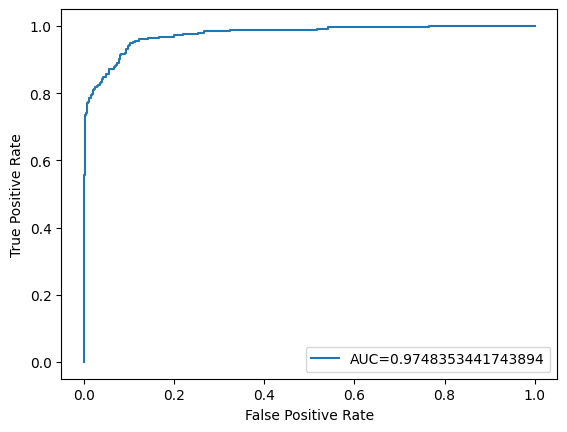

In [ ]:
# ALWAYS reset X columns to the right order
cols_when_model_builds = best_gradBoost.feature_names_in_
X_test=X_test[cols_when_model_builds]



y_thing = y_test.to_numpy()
precision, recall, thresholds = precision_recall_curve(y_thing, best_gradBoost.predict_proba(X_test)[::,1])
aaa = auc(recall, precision)
print("precision recall: " + str(aaa))

y_pred_proba = best_gradBoost.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc_thing = roc_auc_score(y_test, y_pred_proba)

print(y_pred_proba)
plt.plot(fpr,tpr,label="AUC="+str(auc_thing))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()


In [ ]:
# ALWAYS reset X columns to the right order

cols_when_model_builds = best_xgboost.get_booster().feature_names
X_test=X_test[cols_when_model_builds]

y_thing = y_test.to_numpy()
precision, recall, thresholds = precision_recall_curve(y_thing, best_xgboost.predict_proba(X_test)[::,1])
aaa = auc(recall, precision)
print("precision recall: " + str(aaa))

y_pred_proba = best_xgboost.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc_thing = roc_auc_score(y_test, y_pred_proba)

print(y_pred_proba)
plt.plot(fpr,tpr,label="AUC="+str(auc_thing))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

NameError: name 'best_xgboost' is not defined

In [ ]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(best_xgboost, X_test, y_test, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy: 0.945 (0.016)


[0.3 0.1 0.4 ... 0.2 0.2 0.1]


/Users/benjaminli/opt/miniconda3/envs/seq/lib/python3.8/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


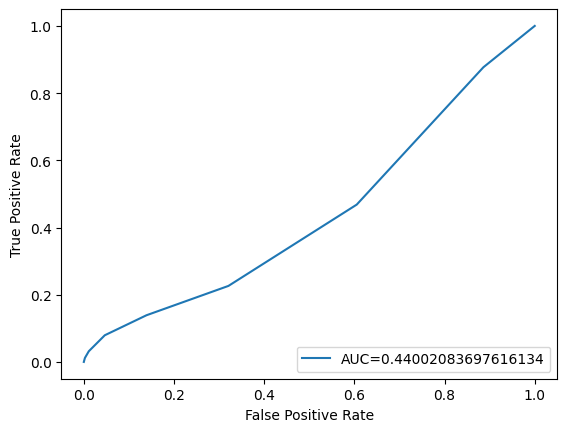

In [ ]:
y_pred_proba = best_rF.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc_thing = roc_auc_score(y_test, y_pred_proba)

print(y_pred_proba)
plt.plot(fpr,tpr,label="AUC="+str(auc_thing))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [ ]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(best_gradBoost, X_test, y_test, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy: 0.946 (0.014)


In [ ]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(best_rF, X_test, y_test, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy: 0.908 (0.016)
